Homework Group A
## Osama Al Kamel / Mtr Num: 3141575
## Joshua Oldridge / Mtr Num: 3140770
---

# Semantic Segmentation - Mini Project Part 1

## Introduction
This notebook shall give you a brief recap of what you have learned in the lecture about image segmentation. <br>
You will again perform image segmentation using the introduced methods in the lecture. But this time some parts are missing and you have to fill them. 

Instructions are given in <span style="color:blue">blue</span> color.

In [80]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import os
import time
print(torch.__version__)
#check if cuda is available
cuda_available = torch.cuda.is_available()
print(f"cuda available: {cuda_available}")
use_cuda = cuda_available

# set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# helper function to count number of parameters in a model
def count_parameters(model):
    params =  sum(p.numel() for p in model.parameters() if p.requires_grad)
    m_params = params / 1e6
    print(f"Model has {m_params:.2f}M parameters")
    

2.2.2
cuda available: True


## Data Understanding and Preparation

For this notebook you will again use the Carla dataset. The preprocessing are taken from the previous notebook.

In [81]:
carla_color_codes = {
    "Unlabeled": (0, 0, 0),
    "Building": (70, 70, 70),
    "Fence": (100, 40, 40),
    "Other": (55, 90, 80),
    "Pedestrian": (220, 20, 60),
    "Pole": (153, 153, 153),
    "RoadLine": (157, 234, 50),
    "Road": (128, 64, 128),
    "Sidewalk": (244, 35, 232),
    "Vegetation": (107, 142, 35),
    "Vehicle": (0, 0, 142),
    "Wall": (102, 102, 156),
    "TrafficSign": (220, 220, 0),
    "Sky": (70, 130, 180),
    "Ground": (81, 0, 81),
    "Bridge": (150, 100, 100),
    "RailTrack": (230, 150, 140),
    "GuardRail": (180, 165, 180),
    "TrafficLight": (250, 170, 30),
    "Static": (110, 190, 160),
    "Dynamic": (170, 120, 50),
    "Water": (45, 60, 150),
    "Terrain": (145, 170, 100)
}

oht_carla_class_indices = {
    0 : "Building",
    1 : "Fence",
    2 : "Pedestrian",
    3 : "Pole", 
    4 : "RoadLine",
    5 : "Road",
    6 : "Sidewalk",
    7 : "Vegetation",
    8 : "Vehicle",
    9 : "Wall",
    10 : "TrafficSign",
    11 : "Sky",
    12 : "GuardRail",
    13 : "TrafficLight",
    14 : "Terrain",
    15 : "Unlabeled"
}

def colorcode_segmentation(np_mask, color_codes, class_indices):
    """colorizes the segmentation mask using the carla color codes"""
    height, width = np_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=int)
    
    for i in np.unique(np_mask):
        rgb_mask[np_mask == i] = color_codes[class_indices[i]]
    return rgb_mask

In [82]:
class CarlaDataset(Dataset):
    def __init__(self, path, image_transform=None, label_transform=None, is_train=True, limit=None):
        self.path = path
        self.limit = limit
        self.is_train = is_train
        self.image_transform = image_transform
        self.label_transform = label_transform
        # list of image, segmentation mask tuples
        self.files = self._get_files()
        self.data = []
        for image, mask in tqdm(self.files):
            self.data.append(self._process(image, mask))

    def _get_files(self):
        # Get all the image files in the directory
        folder = 'train' if self.is_train else 'val'
        image_path = os.path.join(self.path, folder, 'images')
        data_files = []
        for root, _, files in os.walk(image_path):
            for i, file in enumerate(files):
                if file.endswith('.png'):
                    image_file = os.path.join(root, file)
                    segmentation_mask = image_file.replace('images', 'segmentations')
                    data_files.append((image_file, segmentation_mask))
                    if self.limit and i >= self.limit:
                        break
        return data_files
    
    def _process(self, image, mask):
        image = Image.open(image)
        mask = Image.open(mask)
        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            mask = self.label_transform(mask)
        return image, mask

    def __len__(self):
       return len(self.files)
    
    def __getitem__(self, idx):
        return self.data[idx]   

In [83]:
SHAPE = (128, 128)
# image transform to transform the image to tensor, resize and normalize
image_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# for transforming the mask to a tensor with the class labels we will create a custom transform
class MaskToTensor(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mask_values = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 255])

    def __call__(self, mask):
        # Convert PIL Image to numpy array
        segmentation_mask = np.array(mask)
        # Initialize tensor of zeros with the desired shape
        one_hot_mask = torch.zeros((segmentation_mask.shape[0], segmentation_mask.shape[1]))
        
        # Iterate over each unique value in the segmentation mask
        for i, value in enumerate(self.mask_values):
            # Create a binary mask where the value is equal to the unique value
            binary_mask = (segmentation_mask == value)
            # Assign this binary mask to the corresponding index in the tensor
            one_hot_mask[binary_mask] = i
        return one_hot_mask.to(torch.long)

# label transform to transform the label to tensor and resize
label_transform = transforms.Compose([
    transforms.Resize(SHAPE, interpolation=InterpolationMode.NEAREST_EXACT),
    MaskToTensor(16)
])


# test our transformation
image = Image.open("data/Carla_Dataset/train/images/0000.png")
mask = Image.open("data/Carla_Dataset/train/segmentations/0000.png")

mask = label_transform(mask)
print(f"Mask shape: {mask.shape}, unique values: {torch.unique(mask)}, dtype: {mask.dtype}")
image = image_transform(image)
print(f"Image shape: {image.shape}, min: {image.min()}, max: {image.max()}, mean: {image.mean()}, std: {image.std()}, dtype: {image.dtype}")




Mask shape: torch.Size([128, 128]), unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 14, 15]), dtype: torch.int64
Image shape: torch.Size([3, 128, 128]), min: -2.0665297508239746, max: 2.1804091930389404, mean: 0.5448119044303894, std: 0.8206685781478882, dtype: torch.float32


Next the test and traing data are loaded and converted to data loaders.

In [84]:
BATCH_SIZE = 32
# create the dataset
train_dataset = CarlaDataset('data/Carla_Dataset', image_transform, label_transform, is_train=True, limit=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset = CarlaDataset('data/Carla_Dataset', image_transform, label_transform, is_train=False, limit=None)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

100%|██████████| 424/424 [00:08<00:00, 50.76it/s]



Similar to classification tasks, there can be data imbalance in segmentation tasks. To analyze the data imbalance, you are supposed to calculate and visualize the class distribution of the training data. <br>
<div style="color:blue">
Your task is to implement the function `calculate_class_distribution`. This function shall iterate over a given dataset and return a list containing the number of pixels for each class. Also, interpret your results.
</div>


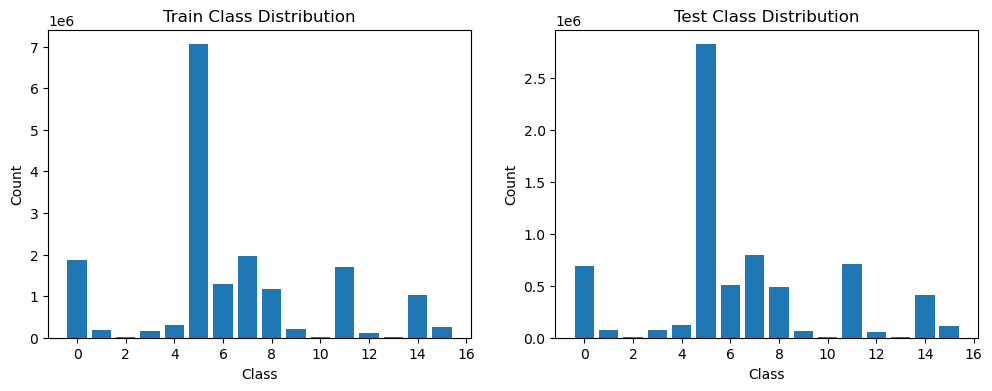

In [85]:
# analyze the per pixel class distribution
def calculate_class_distribution(dataset):
    
    class_counts = [0] * 16

    for image, mask in dataset:

        flat_mask = np.array(mask).flatten()
        
        for class_idx in range(16):
            class_counts[class_idx] += np.sum(flat_mask == class_idx)
    
    return class_counts     
    

train_class_distribution = calculate_class_distribution(train_dataset)
test_class_distribution = calculate_class_distribution(test_dataset)

# plot the class distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.bar(range(16), train_class_distribution)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.subplot(1, 2, 2)
plt.bar(range(16), test_class_distribution)
plt.title("Test Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

*Your interpretation goes here:*<br>
<div style="color:lightblue"> The classes are not equaly distributed, there is way more of class 5 than any other class in both sets, which makes sense as class 5 represents the road, there is also very few pixels that represent class 2, 10 and 13

Next, we take the helper functions from the introduction notebook train and test the model.

In [86]:
def train_one_epoch(model, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    return train_loss / len(train_loader)

def test(model, criterion, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            test_loss += loss.item()
    return test_loss / len(test_loader)
            
def show_img(image):
    min_img = image.min()
    max_img = image.max()
    showimg = ((image-min_img)/(max_img-min_img)).permute(1, 2, 0)
    return showimg
       
def visualize_segmentation(model, test_loader, device):
    # visualize some images
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    output = output.permute(0, 2, 3, 1)
    output = torch.sigmoid(output)
    output = torch.argmax(output, dim=3)
    output = output.cpu().numpy()
    labels = labels.cpu().numpy()

    # Increase the plot size
    plt.figure(figsize=(12, 6))

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(show_img(images[i]).cpu().numpy())
        plt.title('Input Image')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 6)
        plt.imshow(colorcode_segmentation(output[i],carla_color_codes, oht_carla_class_indices))
        plt.title('Predicted Mask')
        plt.axis('off')  # Remove the axis
        plt.subplot(3, 5, i + 11)
        plt.imshow(colorcode_segmentation(labels[i],carla_color_codes, oht_carla_class_indices))
        plt.title('Ground Truth')
        plt.axis('off')  # Remove the axis
    plt.show()


## Modelling

In this notebook, you will again use the simplified U-Net architecture for image segmentation. However, in the introduction notebook, we used the [Transposed Convolution](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) layer to upsample the feature maps. <br>
In this notebook, you shall use the [Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) operation to upsample the feature maps followed by a [2D Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) layer. <br>
<div style="color:blue">
Therefore, your task is to implement the `UpLayerInterpolate` class which shall upsample the input tensor followed by a convolution operation.
</div>

In [87]:

class DownLayer(nn.Module):
    """
    Abstraction of a down layer in a CNN. A down layer consists of a convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(DownLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x
    
class UpLayerTranspose(nn.Module):
    """
    Abstraction of a up layer in a CNN. A up layer consists of a transposed convolutional layer followed by a ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(UpLayerTranspose, self).__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, output_padding=1, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = F.relu(x)
        return x
    
    
class UpLayerInterpolate(nn.Module):
    """
    Abstraction of a up layer in a CNN. A up layer consists of a nearest neighbor interpolation layer followed by a convolutional layer and ReLU activation function.
    """
    def __init__(self, in_channels, out_channels):
        super(UpLayerInterpolate, self).__init__()
        # Intialize the upsample layer and the convolutional layer
        self.up = torch.nn.Upsample(size=None, scale_factor=2, mode='nearest', align_corners=None, recompute_scale_factor=None)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)

        
    def forward(self, x):
        # Implement the forward pass which upsamples the input tensor x and applies the convolutional layer and ReLU activation function
        # solution goes here
        x = self.up(x)
        x = self.conv(x)
        x = F.relu(x)
        return x
    
# test the up layer
up = UpLayerInterpolate(1, 1)
data = torch.randn(1, 1, 16, 16)
output = up(data)
print(f"Output shape: {output.shape}") # If the output shape is torch.Size([1, 1, 32, 32]) then the implementation is correct

Output shape: torch.Size([1, 1, 32, 32])


If you have implemented the `UpLayerInterpolate` class correctly, you can use it to build the the network architecture. We use the same architecture as in the introduction notebook but replace the transposed convolution layers with the `UpLayerInterpolate` layers. <br>

In [88]:

class UnetCNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dims=[32, 64, 128], output_dim=16):
        super(UnetCNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        
        # Encoder layers
        self.encoder_hidden_layers = nn.ModuleList()
        in_dim  = input_dim
        for i in range(0, len(hidden_dims)):
            self.encoder_hidden_layers.append(DownLayer(in_dim, hidden_dims[i]))
            in_dim = hidden_dims[i]
        
        # Decoder layers
        self.decoder_hidden_layers = nn.ModuleList()
        in_dim = hidden_dims[-1]
        for i in range(len(hidden_dims)-1, -1, -1):
            self.decoder_hidden_layers.append(UpLayerInterpolate(in_dim * 2, hidden_dims[i - 1]))
            in_dim = hidden_dims[i - 1]
        self.output_layer = nn.Conv2d(in_dim, output_dim, kernel_size=3, padding=1)

    def forward(self, x):
        # list to store the output of the encoder layers
        output_encoder = []
        # forward pass trough the encoder
        for hidden_layer in self.encoder_hidden_layers:
            x = hidden_layer(x)
            x = F.relu(x)
            # store the output of the encoder layers
            output_encoder.append(x)

        # forward pass trough the decoder
        for i, hidden_layer in enumerate(self.decoder_hidden_layers):
            # concatenate the output of the encoder layers
            x = torch.cat([x, output_encoder[-i - 1]], dim=1)
            x = hidden_layer(x)
            x = F.relu(x)
        x = self.output_layer(x)
        return x
    
# test if our model works for segmentation by keeping the original input dimensions
model = UnetCNN()
test_image = torch.rand(1, 3, 128, 128)
output = model(test_image)
print(f"Input shape: {test_image.shape}, output shape: {output.shape}")
assert test_image.shape[2:] == output.shape[2:], "Input and output dimensions should be the same"


Input shape: torch.Size([1, 3, 128, 128]), output shape: torch.Size([1, 16, 128, 128])


## Training
Next we initialize the network and define the loss function and optimizer.

In [89]:
# create the network
model = UnetCNN(hidden_dims=[16, 32, 64, 128])
count_parameters(model)
# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# create the loss function
criterion = nn.CrossEntropyLoss()
# set the device
device = torch.device("cuda" if use_cuda else "cpu")
model.to(device)

Model has 0.35M parameters


UnetCNN(
  (encoder_hidden_layers): ModuleList(
    (0): DownLayer(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (1): DownLayer(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (2): DownLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (3): DownLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder_hidden_layers): ModuleList(
    (0): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): UpLayerInterpolate(
      (up): Upsample(scale_factor=2.0, mode='nearest')
      (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1,

Now train the model.

In [90]:
EPOCHS = 20
train_losses = []
test_losses = []
start_time = time.time()
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    train_loss = train_one_epoch(model, optimizer, criterion, train_loader)
    test_loss = test(model, criterion, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    pbar.set_description(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')
end_time = time.time()
print(f"Training time in minutes: {(end_time - start_time) / 60:.2f} on {device} for {EPOCHS} epochs")

Epoch 20, Train Loss: 0.4478, Test Loss: 0.5426: 100%|██████████| 20/20 [00:52<00:00,  2.65s/it]

Training time in minutes: 0.88 on cuda for 20 epochs


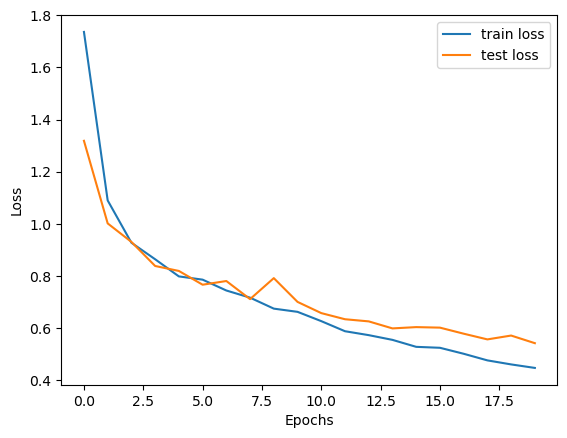

In [91]:
# plot the train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div style="color:blue">
Interpret the loss curve. What can you say about the training process? 
</div>

*Your Solution goes here:* <br>
<div style="color:lightblue">
The loss is decreasing for both the train and test data as we train the model for more epochs, this shows that the model is improving in accuracy as we train it more




## Evaluation
Next, we evaluate the model on the test data. To do so, we again use the accuracy. But this time, we also use the Intersection over Union (IoU) metric. <br>

<img src="img/iou_target.png" alt="IoU" style="width: 800px;"/> <br>
<img src="img/iou_example.png" alt="IoU" style="width: 800px;"/> <br>
[Source](https://www.jeremyjordan.me/evaluating-image-segmentation-models/) <br>



The IoU metric is defined as the intersection of the predicted (A) and ground truth (B) mask divided by the union of the predicted and ground truth mask. <br>

$IoU = \frac{A \cap B}{A \cup B}$ <br>

The intersection $(A \cap B)$ is comprised of the pixels found in both the prediction mask and the ground truth mask, whereas the union $(A \cup B)$ is simply comprised of all pixels found in either the prediction or target mask. <br>

The IoU score is calculated for each class separately and then averaged over all classes to provide a global, mean IoU score of our semantic segmentation prediction. <br>

<div style="color:blue">
Your task is to use the function <tt>iou</tt> which takes the predicted and target masks and calculates the mean IoU score. To do so, you first have to implement the <tt>intersection</tt> and <tt>union</tt> functions. <br>
Afterwards, you can use the <tt>iou</tt> function to calculate the IoU score for the test data.
</div>

In [96]:
def intersection(prediction, target, relevant_class=1):
    """
    Calculate the intersection between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the intersection for
    """
    # Your solution goes here
    # calculate the intersection
    
    pred_mask = (prediction == relevant_class)
    target_mask = (target == relevant_class)
    
    
    intersection = torch.Tensor.sum(pred_mask & target_mask)

    return intersection

def union(prediction, target, relevant_class=1):
    """
    Calculate the union between the prediction and the target for a specific class
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - relevant_class: the class index that we are interested in calculating the union for
    """
    # Your solution goes here
    # calculate the union
    pred_mask = (prediction == relevant_class)
    target_mask = (target == relevant_class)
    
    union = torch.Tensor.sum(pred_mask | target_mask)
    return union


def iou(prediction, target):
    """
    Calculate the mean intersection over union for the prediction and target
    Args:
    - prediction: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    # calculate the number of classes
    class_indices = torch.unique(target)
    # initialize the list to store the iou for each class
    iou_per_class = []
    # iterate over each class
    for i in class_indices:
        # calculate the intersection for the class
        inter = intersection(prediction, target, i)
        # calculate the union for the class
        uni = union(prediction, target, i)
        # calculate the iou for the class
        iou = inter / uni
        iou_per_class.append(iou)
    # calculate the mean iou
    
    return torch.mean(torch.Tensor(iou_per_class)).item()    
    
# test the implementation 
prediction = torch.tensor([[[1, 2 , 1], [1, 1, 1], [2, 2, 2]]])
target = torch.tensor([[[1, 1, 1], [1, 2, 1], [2, 1, 2]]])
print(f"IOU: {iou(prediction, target)}") # If the IOU is ~0.4857 then the implementation is correct

IOU: 0.485714316368103


In [97]:
def accuracy(output, target):
    """
    Function to calculate the accuracy given the output and target
    Args:
    - output: the predicted segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    - target: the target segmentation mask of shape (N, H, W) where N is the batch size and H, W are the height and width of the mask
    """
    accuracy = torch.sum(output == target) / (output.shape[0] * output.shape[1] * output.shape[2])
    return accuracy.item()
    

def validate(model, test_loader, device):
    model.eval()
    accuracy_list = []
    iou_list = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            # argmax to get the class index
            output = torch.argmax(output, dim=1)
            accuracy_list.append(accuracy(output, labels))
            iou_list.append(iou(output, labels))
    mean_accuracy = sum(accuracy_list) / len(test_loader)
    mean_iou = sum(iou_list) / len(test_loader)
    return mean_accuracy, mean_iou


m_accuracy, m_iou = validate(model, test_loader, device)
print(f'Accuracy: {m_accuracy}, IoU: {m_iou}')

100%|██████████| 14/14 [00:00<00:00, 23.31it/s]

Accuracy: 0.8350193841116769, IoU: 0.35023907465594156


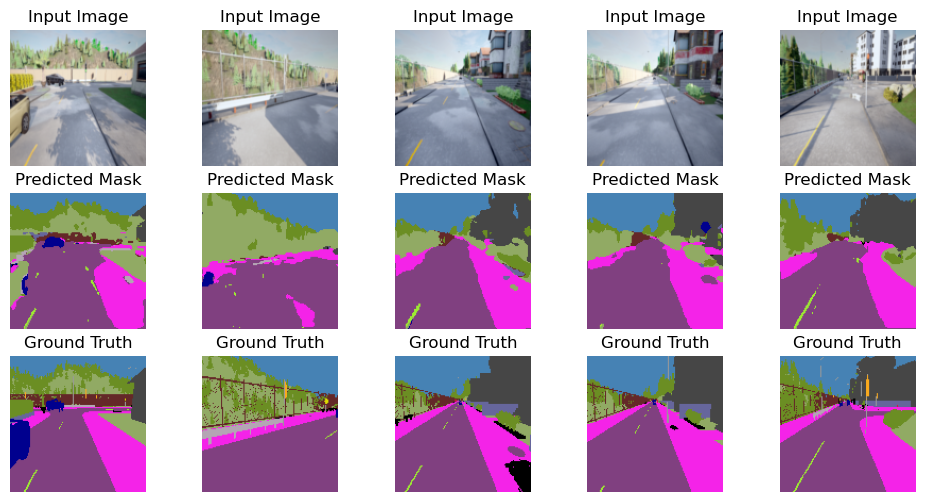

In [98]:
visualize_segmentation(model, test_loader, device)

Once you have finished this notebook, you can move on the the second notebook where you will find the introduction to the segmentation mini project.